In [1]:
import pyLCR
import os
import urllib
import json
import numpy as np
import io
import sys
import math
from statistics import mode

import astropy
from astropy.table import Table, Column
from astropy.time import Time
from astropy.io import fits
import pandas as pd
import array as arr

from pyLCR.DataTools import getLightCurve
from pyLCR.PlottingTools import plotLightCurve
from pyLCR.PlottingTools import computeDate
from pyLCR.PlottingTools import getCurrentMET
from pyLCR.PlottingTools import computeMJD
from pyLCR.Sources import sources

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.stats import bayesian_blocks
import qb
import hop


The Fermi-LAT Light Curve Repository Toolkit v0.1.0
Support Contact: Daniel Kocevski (daniel.kocevski@nasa.gov)


In [2]:
def filter_data(n):
 
    #creat list inside dictionary
    list_of_bad_indexes[n] = np.array([], dtype=int)
    

    #print(type(n))#make sure data is being read as str
    #check if the sourse contains data
    data = pyLCR.getLightCurve(n, cadence='daily', flux_type='photon', index_type='fixed', ts_min=1)
    if data is None:
        return()  
    else:
      # Access and print the 'flux_error' attribute if data is not None
        if hasattr(data, 'flux_error'):
            data.ts = data.ts[data.ts >= 1]
            print (len(data.flux))
            bad_ids = np.where(data.flux >= 1e-4)[0]#first filter for if a source is too bright
            list_of_bad_indexes[n]= np.append(list_of_bad_indexes[n],bad_ids)#append the too bright indexes to our bad indexes
            
     
            for t in range(1, len(data.met_detections)-1):#nested loop with reference to time
                if t in list_of_bad_indexes[n]:
                    pass
               
                elif (data.flux[t]/(data.flux_error[t][1]-data.flux[t]))**2 > 300*data.ts[t]:#find outliars
                     list_of_bad_indexes[n]= np.append(list_of_bad_indexes[n],t)#add to bad list
                elif (data.flux[t]/(data.flux_error[t][0]-data.flux[t]))**2 > 300*data.ts[t]:
                     list_of_bad_indexes[n]= np.append(list_of_bad_indexes[n],t)
                    
              
            
            
            
            #make data type bool where bad indexes is false  
            mask = np.ones(len(data.flux), dtype=bool)
            mask[list_of_bad_indexes[n]] = False #make them hidden
            print('Number of bad indexes:')
            print(len(list_of_bad_indexes[n]))
            #make 'good' data what is left when bad inexes are masked
            good_flux[n]= data.flux[mask]
            good_errs[n]= data.flux_error[mask]
            good_dets[n]=convert_mjds(data.met_detections[mask])
            list_of_good_names.append(str(n))
            #print('Number of good flux bins:')
            #print (len(good_flux[n]))
        else:
            return()

        return()  


def convert_mjds(mets):
   
    met_start=239889601 #start of survey in secs
    mjd_start=54686.5 #start in days
    mjd_values=((mets-met_start)/86400)+mjd_start #conversion
    return (mjd_values)#days not seconds 

In [3]:
strong_flares=np.array(['4FGL J0222.6+4302',
                        '4FGL J0538.8-4405',
                        '4FGL J0725.2+1425',
                        '4FGL J1146.9+3958',
                        '4FGL J1159.5+2914',
                        '4FGL J1229.0+0202',
                        '4FGL J1239.5+0443',
                        '4FGL J1345.5+4453',
                        '4FGL J1427.0+2348',
                        '4FGL J1427.6-3305',
                        '4FGL J1625.7-2527',
                        '4FGL J1626.0-2950',
                        '4FGL J2232.6+1143',
                        '4FGL J2253.9+1609'])

In [4]:
def block_good_fluxes(times, fluxes, errors):
 
   
    edges = bayesian_blocks(times, fluxes, sigma=(errors.max(axis=1)-fluxes),fitness='measures')
    #edges = bayesian_blocks(good_dets[name], good_flux[name], sigma=(good_errs[name].max(axis=1)-good_flux[name]),fitness='measures')
    blocked_flux = []
    blocked_errs = []
    blocked_edges = []
    try:
        quiescent_baseline = np.median(qb.find_quiet(fluxes))
        #quiescent_baseline[n] = np.median(qb.find_quiet(good_flux[n]))
    except:
        quiescent_baseline = np.median(fluxes)
        #quiescent_baseline[n] = np.median(good_flux[n])
        
    for i in range(len(edges) - 1):
        
        temp_errs = errors[(times >= edges[i]) & (times < edges[i+1])][:,0]
        temp_flux= fluxes[(times >= edges[i]) & (times < edges[i+1])] 
        #temp_errs = good_errs[name][(good_dets[name] >= edges[i]) & (good_dets[name] < edges[i+1])][:,0]
        #temp_flux= good_flux[name][(good_dets[name] >= edges[i]) & (good_dets[name] < edges[i+1])]
        temp_errs-=temp_flux
        if len(temp_errs)<1:
            pass
                
        else: 
            #prop errs
            weights= 1/temp_errs**2
            weighted_mean= np.average(temp_flux,weights=weights)
            weighted_error= np.sqrt(1/np.sum(weights))
            blocked_flux.append(weighted_mean)
            blocked_errs.append(weighted_error)
            blocked_edges.append(edges[i])
                
    blocked_edges.append(edges[-1])
    blocked_edges= np.array(blocked_edges)
    blocked_flux = np.array(blocked_flux)
    blocked_errs= np.array(blocked_errs)
    
    #all_blocked_flux[name]= blocked_flux
    #all_edges[name]= blocked_edges
    #all_blocked_errs[name]= blocked_errs
    return(blocked_edges, blocked_flux, blocked_errs, quiescent_baseline)
        
def plot_blocks_vs_data(names, num_of_cols=2):
    '''
    This function only takes the list of names you want to plot;
    it assumes that there is already a dictionary of filtered data 
    (good_dets, good_flux, good_errs) that includes every name 
    from the list of names that you gave it.
    
    It also assumes there is already a dictionary of blocked data 
    (all_blocked_flux, all_edges) for every name as well.
    
    Finally, it assumes that there is also a dictionary of the quiscent
    flux (quiescent_baseline) for every name as well.
    
    This will make a plot that is 2 columns wide, and is therefore half
    as long as all the data you want to plot. If you are plotting more
    than ~20 sources, I recommmend increasing the number of columns
    (and therefore also decreasing the number of rows). This is why I've
    added the variable num_of_cols, which is set to a default of 2,
    but when you call the function you can just set num_of_cols=3 (or anything!).
    Every time you increase the # of columns, you divide the # of rows
    by the same amount - this is hard-coded into the first line.
    '''
    fig, ax = plt.subplots(int(len(names)/num_of_cols), num_of_cols, figsize=(12,20), dpi=200,sharex=True)
    # Uncommment the following line if you want to plot the original data for this source
    #orig = pyLCR.getLightCurve(name, cadence='daily', flux_type='photon', index_type='fixed', ts_min=1, verbose=False)
    j=0
    m=0 #start collums at 0
    for name in names:
        #ax[j,m].plot(orig.met_detections, orig.flux, color='blue', alpha=0.7)
        ax[j,m].errorbar(good_dets[name], good_flux[name], yerr=good_errs[name].max(axis=1)-good_flux[name], fmt='.', elinewidth=1, color='grey',alpha=0.2) 
        ax[j,m].stairs(all_blocked_flux[name], edges=all_edges[name], fill=False, zorder=3, color='black')
        ax[j,m].text(.01,.9,name,transform=ax[j, m].transAxes)
        ax[j,m].axhline(quiescent_baseline[name], color='hotpink', linestyle='--', zorder=10)
        j += 1 #next row
        if j == int(len(names)/2):
            m=1 #switch collum
            j=0 #restart 0
            if m == num_of_cols:
                break

    fig.subplots_adjust(wspace=0.1, hspace=0.0)
    plt.show()


def flare_counting(blocked_flux_array,qb):
   
    if (len(blocked_flux_array))!=1:
    
        loc_of_flares=hop.hop(blocked_flux_array)
        good_flare= np.where(blocked_flux_array> 5* np.median(qb))[0]
        overlapping_ids = list(set(loc_of_flares) & set(good_flare))
    else:

        overlapping_ids=[]
   
        
    return (overlapping_ids)

In [5]:
list_of_blazars = np.genfromtxt('fgl4_dr2_blazars.dat', delimiter=',', dtype=str) #read in data
#names = list_of_blazars
names=strong_flares

#names=np.append(names,'4FGL J0001.5+2113')

#dictionaries  
list_of_bad_indexes = {} #to track data that should be filtered out
good_flux = {} #filtered fluxes per source
good_errs = {} #errors of the filtered fluxes per source
good_dets = {} #times associated with each filtered flux (MJD) per source
list_of_good_names =[] #list of names (sources) that had data tracked by pyLCR thus were filtered
all_blocked_flux={} #blocked fluxes per source
all_edges={} #edges of the bluxes per source
all_blocked_errs={} #errors of the blocked flux per source
quiescent_baseline = {} #ground flux (quiescent baseline) per source

In [6]:
#This cell uses our created function, filter_data, to find and save
#the good, filtered data of every source in a dictionary, 
#where every dictionary entry (by using [n]) is the source.



for n in names:
    filter_data(n)

#list_of_good_names = np.array(list_of_good_names)


Done.
1796
Number of bad indexes:
4

Done.
1933
Number of bad indexes:
0

Done.
1062
Number of bad indexes:
4

Done.
1505
Number of bad indexes:
0

Done.
1680
Number of bad indexes:
2



/var/folders/j8/7gq1bnh57b91385bdgsjkp_m0000gn/T/ipykernel_83255/2377255017.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  elif (data.flux[t]/(data.flux_error[t][1]-data.flux[t]))**2 > 300*data.ts[t]:#find outliars


Done.
1733
Number of bad indexes:
0

Done.
1395
Number of bad indexes:
0

Done.
1562
Number of bad indexes:
0

Done.
1859
Number of bad indexes:
0

Done.
579
Number of bad indexes:
0

Done.
940
Number of bad indexes:
7

Done.
973
Number of bad indexes:
5

Done.
1852
Number of bad indexes:
0

Done.
1937
Number of bad indexes:
0


In [7]:
#This cell uses our created function, block_good_fluxes, to find and save
#the Bayesian Block details and quiescent baseline of every source
#in a dictionary, where every dictionary entry (by using [n]) is the source.


for n in names:
    if n not in good_flux: 
        continue    
    else:
        all_edges[n], all_blocked_flux[n], all_blocked_errs[n], quiescent_baseline[n] = block_good_fluxes(good_dets[n], good_flux[n], good_errs[n])


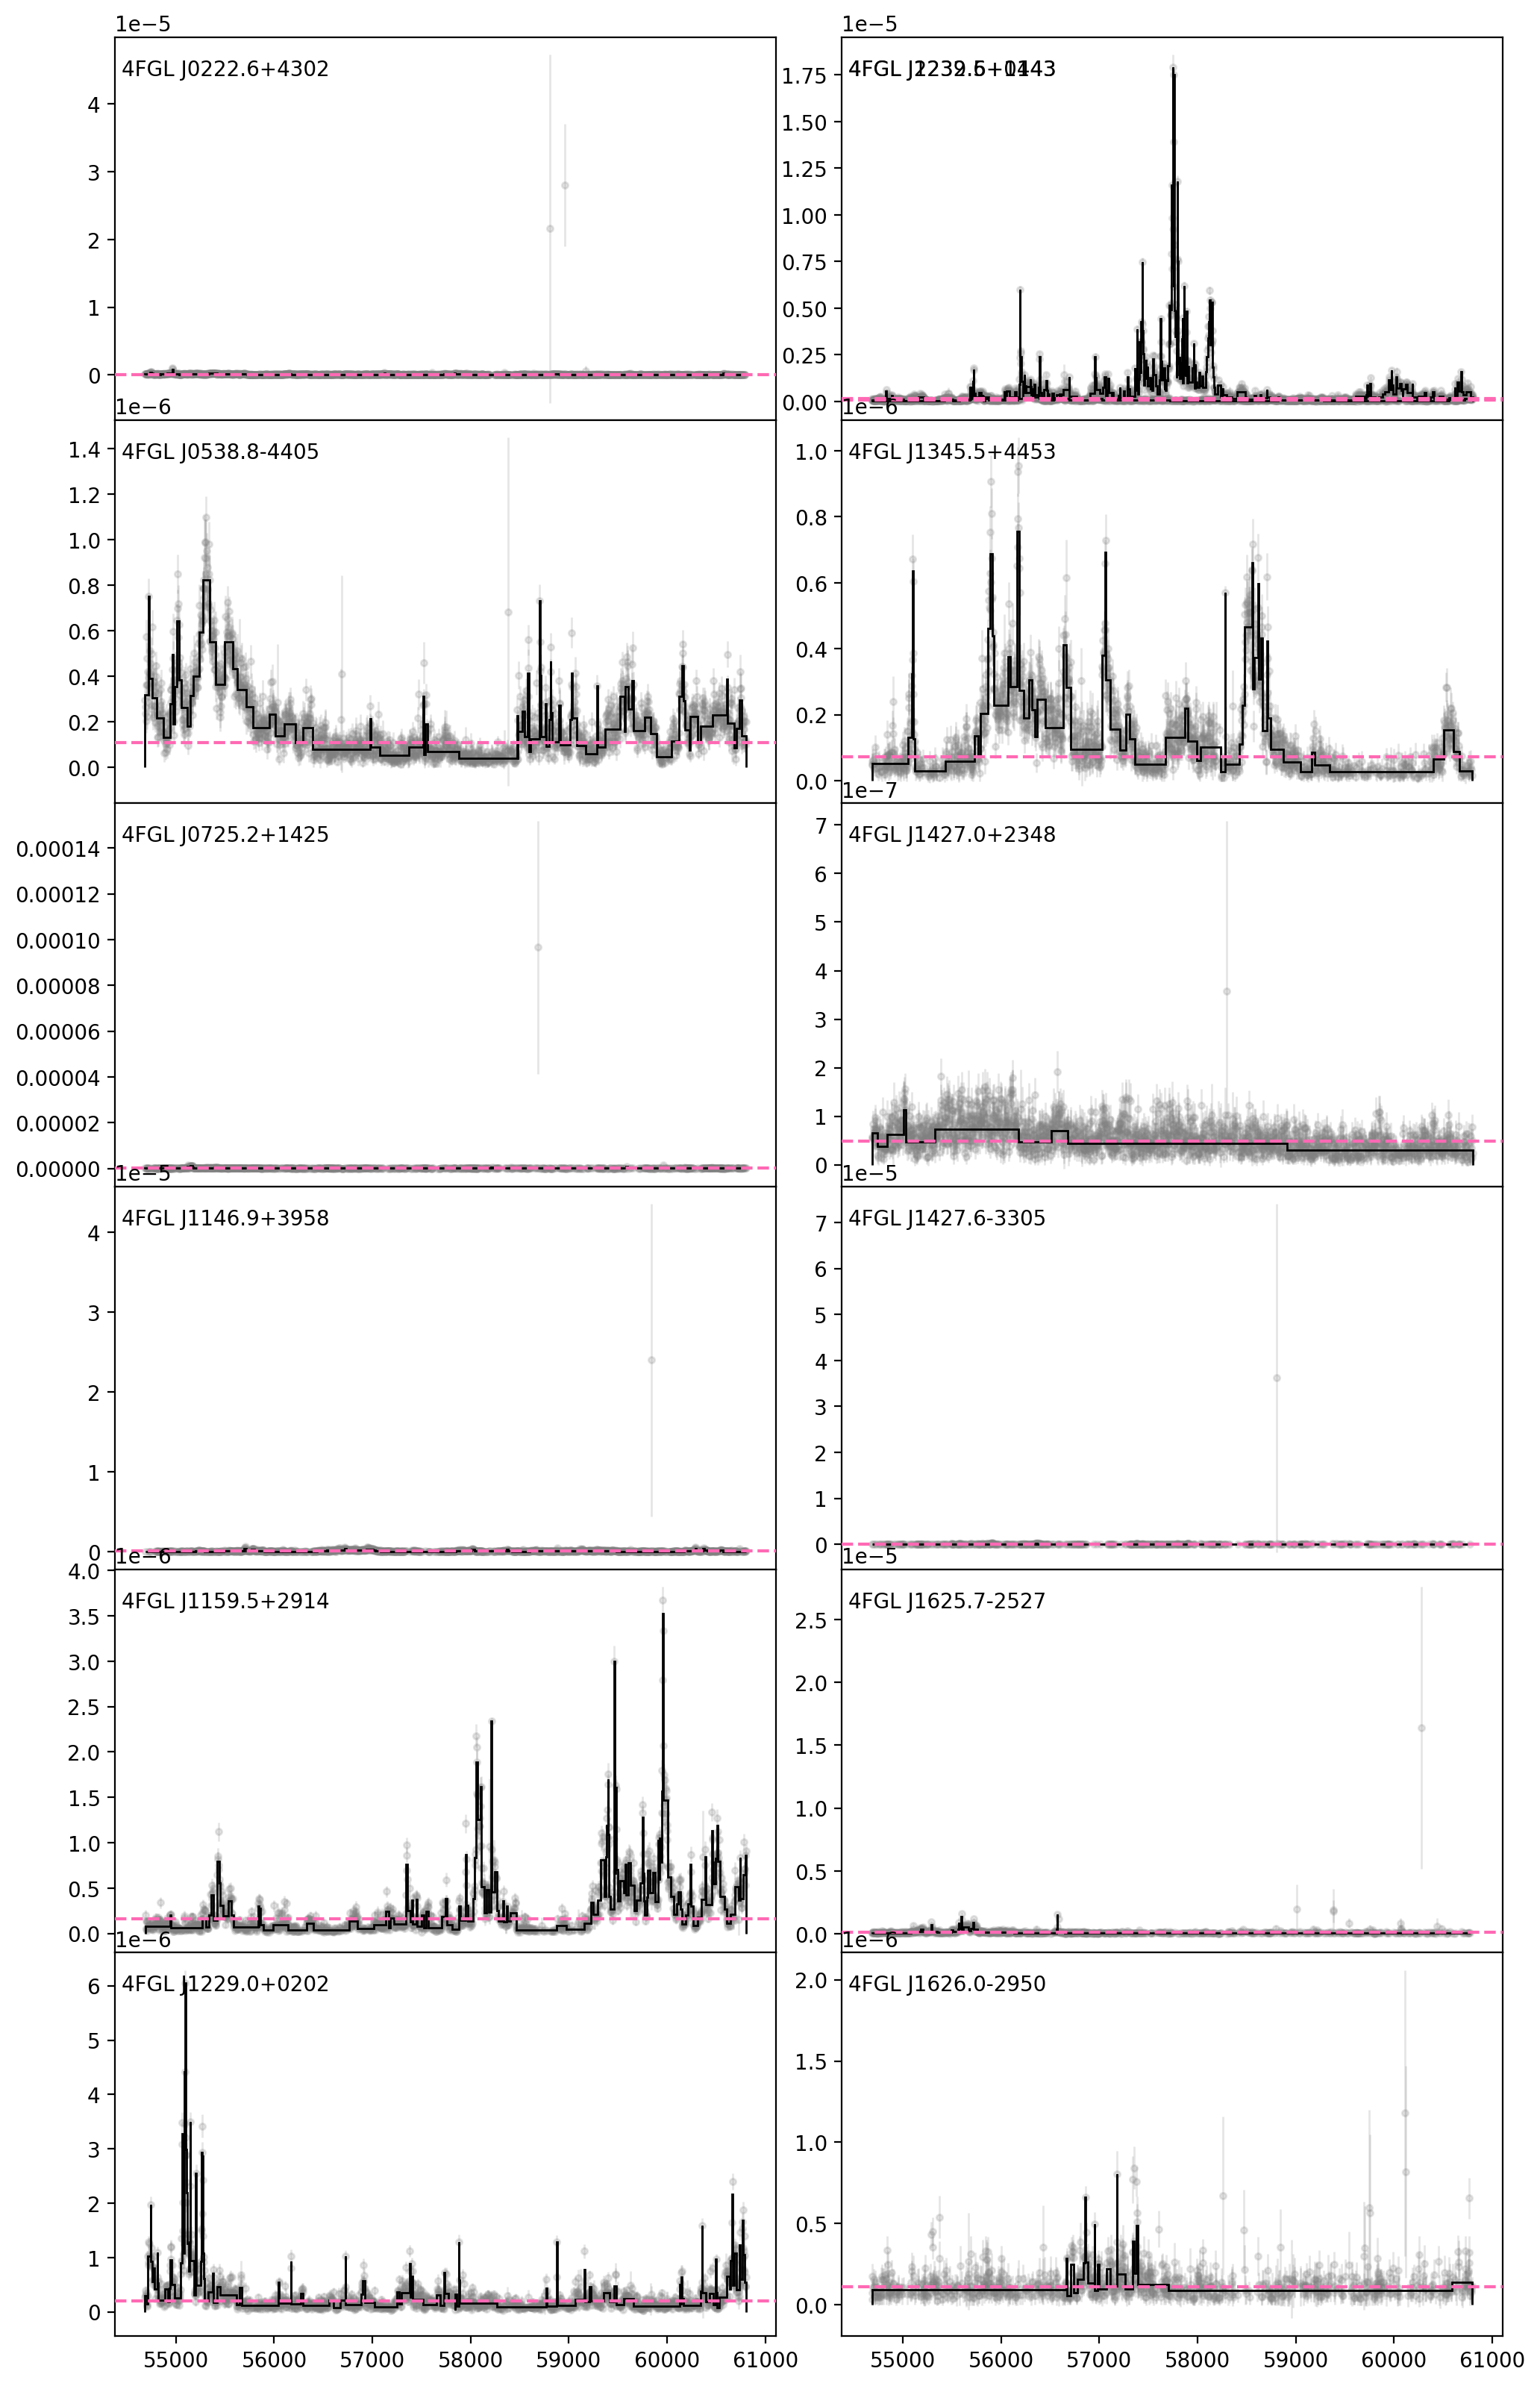

In [8]:
#This cell plots the raw, blocked, and quiescent data for each source.

# I'm doing everything but the last source because our list happens to be an odd number
# right now, and I don't want the last source over-plotting on top of other data.

plot_blocks_vs_data(list_of_good_names[:-1])

Text(0.5, 0, 'number of flares per source')

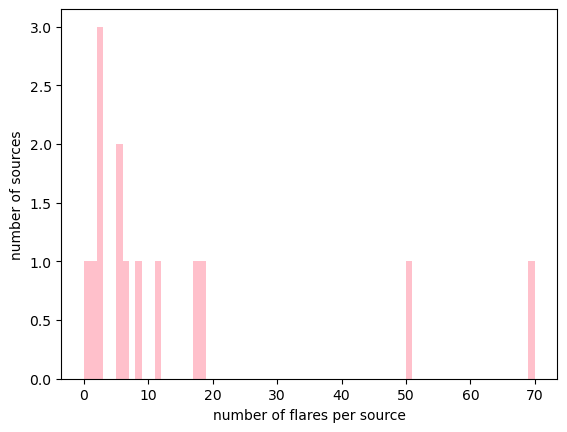

In [39]:
list_of_good_flares ={}
num_of_flares_per_source=[]

            

for n in list_of_good_names:
    ids_of_flares=flare_counting(all_blocked_flux[n],quiescent_baseline[n])
    num_of_flares_per_source.append(len(ids_of_flares))
    list_of_good_flares[n]=ids_of_flares
    


    
plt.figure()   
plt.hist(num_of_flares_per_source,bins=range(max(num_of_flares_per_source)+1),color='pink')
plt.ylabel('number of sources')
plt.xlabel('number of flares per source')


In [49]:
hdulist = [fits.PrimaryHDU()]  # Start with an empty primary HDU

for name in list_of_good_names:  # Loop over your blazar sources
    # Filtered data table
    cols_filt = [
        fits.Column(name='MJD', array=good_dets[name], format='E'),
        fits.Column(name='Flux', array=good_flux[name], format='E'),
        fits.Column(name='Error_lower', array=good_errs[name][:,0], format='E'),
        fits.Column(name='Error_upper', array=good_errs[name][:,1], format='E')
    ]
    hdu_filt = fits.BinTableHDU.from_columns(cols_filt, name=f'{name}_FILTERED')

    # Bayesian block data table
    if len(all_edges[name]) > 0:
        cols_blocked = [
            fits.Column(name='Edge', array=np.array(all_edges[name]), format='E'),
            fits.Column(name='Flux', array=np.array(all_blocked_flux[name]), format='E'),
            fits.Column(name='Error', array=np.array(all_blocked_errs[name]), format='E')
            ]
        hdu_blocked = fits.BinTableHDU.from_columns(cols_blocked, name=f'{name}_BLOCKED')
    else:
        cols_blocked = [
            fits.Column(name='Edge', array=np.array([]), format='E'),
            fits.Column(name='Flux', array=np.array([]), format='E'),
            fits.Column(name='Error', array=np.array([]), format='E')
            ]
        hdu_blocked = fits.BinTableHDU.from_columns(cols_blocked, name=f'{name}_BLOCKED')
    # Add to HDU list
    hdulist.extend([hdu_filt, hdu_blocked])

# Write to disk
fits.HDUList(hdulist).writeto('blazar_lightcurves.fits', overwrite=True)


In [50]:
hdu=fits.open('blazar_lightcurves.fits')
print(len(list_of_good_names))
hdu.info()


1415
Filename: blazar_lightcurves.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  4FGL J0001.2-0747_FILTERED    1 BinTableHDU     17   491R x 4C   [E, E, E, E]   
  2  4FGL J0001.2-0747_BLOCKED    1 BinTableHDU     15   2R x 3C   [E, E, E]   
  3  4FGL J0001.5+2113_FILTERED    1 BinTableHDU     17   834R x 4C   [E, E, E, E]   
  4  4FGL J0001.5+2113_BLOCKED    1 BinTableHDU     15   37R x 3C   [E, E, E]   
  5  4FGL J0003.3-1928_FILTERED    1 BinTableHDU     17   405R x 4C   [E, E, E, E]   
  6  4FGL J0003.3-1928_BLOCKED    1 BinTableHDU     15   2R x 3C   [E, E, E]   
  7  4FGL J0004.3+4614_FILTERED    1 BinTableHDU     17   390R x 4C   [E, E, E, E]   
  8  4FGL J0004.3+4614_BLOCKED    1 BinTableHDU     15   2R x 3C   [E, E, E]   
  9  4FGL J0004.4-4737_FILTERED    1 BinTableHDU     17   480R x 4C   [E, E, E, E]   
 10  4FGL J0004.4-4737_BLOCKED    1 BinTableHDU     15   5R x 3C   [E, E, E]   
 11  4FGL J0005.9

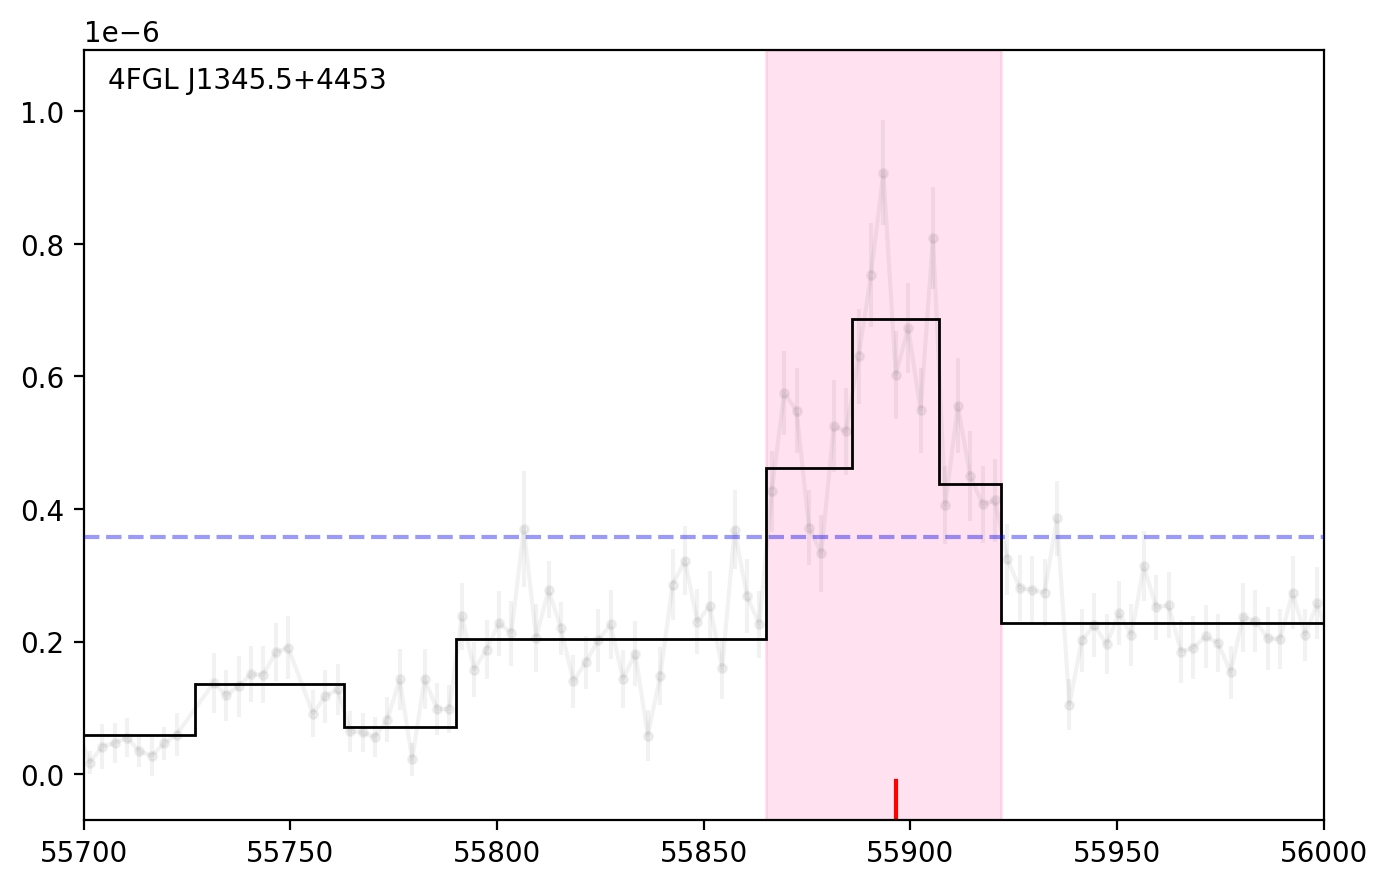

In [9]:
count=0
flare=0
random_name = list_of_good_names[7]

ids = []

time_elapsed = {random_name:[]}

qb = 5 * quiescent_baseline[random_name]

all_edges_loop = all_edges[random_name][:-1]

for i in range(len(all_edges_loop)):
    if all_blocked_flux[random_name][i] > qb:
        # This will handle single-index flares
        if all_blocked_flux[random_name][i-1] < qb:
            # This handles when the last index is still in the flare
            if i == (len(all_edges_loop)-1):
                flare += 1
                time_elapsed[random_name].append(all_edges[random_name][i+1]
                                                 - all_edges[random_name][i])
                ids.append(i)
                ids.append(i+1)
            # This handles if we KNOW the indices before+after are below threshold
            elif all_blocked_flux[random_name][i+1]< qb:
                flare += 1
                time_elapsed[random_name].append(all_edges[random_name][i+1]
                                                 - all_edges[random_name][i])
                ids.append(i)
                ids.append(i+1)
       
        # Now for multi-index ones
        else:
            count += 1
            if count == 1:
                first_index = i-1
                ids.append(first_index)
       
            if all_blocked_flux[random_name][i-1]> qb:
                if i == (len(all_edges_loop)-1):
                    flare += 1
                    last_index = i
                    time_elapsed[random_name].append(all_edges[random_name][i]
                                                     - all_edges[random_name][first_index])
                    ids.append(last_index)
           
                elif all_blocked_flux[random_name][i+1]< qb:
                    flare += 1
                    last_index = i+1
                    time_elapsed[random_name].append(all_edges_loop[last_index]
                                                    - all_edges_loop[first_index])
                    count = 0
                    ids.append(last_index)
ids = np.array(ids)  

rise_count=0
decay_count=0
'''
if flux[i+1]>[i] and > qb:
    rise_count+=1
if flux[i+1]<[i] and > qb:
    decay_count+=1     #not sure how to account for when there are multiple little rises/decays in one flare
#i think there is really simple code here to tell each separate flare and how many days/counts it spends in rise vs decay
'''

fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=200)
ax.errorbar(good_dets[random_name], good_flux[random_name], yerr=good_errs[random_name].max(axis=1)-good_flux[random_name],
            marker='.', color='k', alpha=0.05)
ax.stairs(all_blocked_flux[random_name], edges=all_edges[random_name], fill=False, zorder=3, color='black')
#ax.scatter(all_edges[random_name][ids], np.ones_like(ids)*all_blocked_flux[random_name][ids], color='r', marker='*')
ax.text(0.02, 0.95, random_name, transform=ax.transAxes)
ax.axhline(qb, color='blue', alpha=0.4, linestyle='--', zorder=10)
ax.set_xlim(55700, 56000)
i=0
while i <= (len(ids)-1):
    ax.axvspan(all_edges[random_name][ids[i]],all_edges[random_name][ids[i+1]],alpha=0.2, color= 'hotpink')
    v_line=np.argmax(all_blocked_flux[random_name][ids[i]:ids[i+1]+1])
    loc_of_v_line= all_edges[random_name][ids[i]:ids[i+1]+1][v_line]
    loc_of_v_line_next= all_edges[random_name][ids[i]:ids[i+1]+1][v_line+1]
    loc_of_plot=np.mean([loc_of_v_line,loc_of_v_line_next])
    ax.axvline(loc_of_plot, ymax=0.05, color='red')
    i+=2

plt.show()
